In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx

from PIL import Image
from IPython.display import display, Video
import cv2
import os

# Getting IFS data

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
cat.IFS

IFS:
  args:
    path: https://raw.githubusercontent.com/nextGEMS/catalog/main/IFS/main.yaml
  description: IFS model output
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://data.nextgems-h2020.eu


In [3]:
print(list(cat.IFS))
(list(cat.IFS['IFS_4.4-FESOM_5-cycle3']))

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']


['2D_1h_native',
 '3D_1h6h_native',
 '2D_monthly_native',
 '3D_monthly_native',
 '2D_monthly_0.25deg',
 '3D_monthly_0.25deg',
 '2D_1h_0.25deg',
 '3D_1h6h_0.25deg',
 '2D_monthly_1deg',
 '3D_monthly_1deg',
 '2D_1h_1deg',
 '3D_1h6h_1deg',
 'WAM_1h_native']

In [4]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load medium-resolution here, monthly means
ds

<xarray.Dataset>
Dimensions:  (time: 43394, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

# Calculation for water retention

In [5]:
# Calculate saturation vapor pressure (in Pa) for a given temperature T (in K)
def saturation_vapor_pressure(T):
    """ 
    T: Temperature in Kelvin
    Returns: Saturation vapor pressure in Pascals
    """
    T_C = T - 273.15  # Convert temperature to Celsius
    return 611.2 * np.exp((17.67 * T_C) / (T_C + 243.5))

# Calculate specific humidity using saturation vapor pressures and surface pressure
def specific_humidity(e_d, e_s, sp):
    """ 
    e_d: Saturation vapor pressure at dew point temperature in Pascals
    e_s: Saturation vapor pressure at surface temperature in Pascals
    sp: Surface pressure in Pascals
    Returns: Specific humidity in kg/kg
    """
    return 0.622 * (e_d / sp)

# Calculate evapotranspiration using surface latent heat flux
def evapotranspiration(slhf):
    """ 
    slhf: Surface latent heat flux in J m**-2
    Returns: Evapotranspiration in meters
    """
    lv = 2.5e6  # Latent heat of vaporization for water in J/kg
    return slhf / lv

# Calculate water retention potential
def water_retention_potential(tp, ET):
    """ 
    tp: Total precipitation in meters
    ET: Evapotranspiration in meters
    Returns: Water retention potential in meters
    """
    return tp - ET

# Extract the necessary variables from the dataset
slhf = ds['slhf']  # Surface latent heat flux in J m**-2
d2 = ds['2d']  # 2m dew point temperature in Kelvin
t2 = ds['2t']  # 2m surface temperature in Kelvin
sp = ds['sp']  # Surface pressure in Pascals
tp = ds['tp']  # Total precipitation in meters

# Calculations
e_d = saturation_vapor_pressure(d2)
e_s = saturation_vapor_pressure(t2)
q = specific_humidity(e_d, e_s, sp)
ET = evapotranspiration(slhf)
WaterRetention = water_retention_potential(tp, ET)

WaterRetention
# # Compute the results (since Dask uses lazy evaluation)
# q = q.compute()
# ET = ET.compute()
# WaterRetention = WaterRetention.compute()

# print(f"Specific Humidity (mean): {q.mean()} kg/kg")
# print(f"Evapotranspiration (mean): {ET.mean()} m")
# print(f"Water Retention Potential (mean): {WaterRetention.mean()} m")


<xarray.DataArray (time: 43394, value: 26306560)>
dask.array<sub, shape=(43394, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value

In [6]:
print(WaterRetention.coords)

Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01


# Setting the grid for selected region

In [7]:
# This extracts longitude (lon) and latitude (lat) values from the dataset.
model_lon = WaterRetention.lon.values
model_lat = WaterRetention.lat.values
# It then identifies locations where neither longitude nor latitude is NaN (Not a Number) and stores this in the nonan variable.
# Using this nonan mask, it filters out NaN values from both longitude and latitude arrays.
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
# Finally, the longitudes and latitudes are stacked vertically and transposed to create an array of points (points_ifs).
points_ifs = np.vstack((lon_nonan, lat_nonan)).T
points_ifs

array([[  0.        ,  89.97309123],
       [ 18.        ,  89.97309123],
       [ 36.        ,  89.97309123],
       ...,
       [-54.        , -89.97309123],
       [-36.        , -89.97309123],
       [-18.        , -89.97309123]])

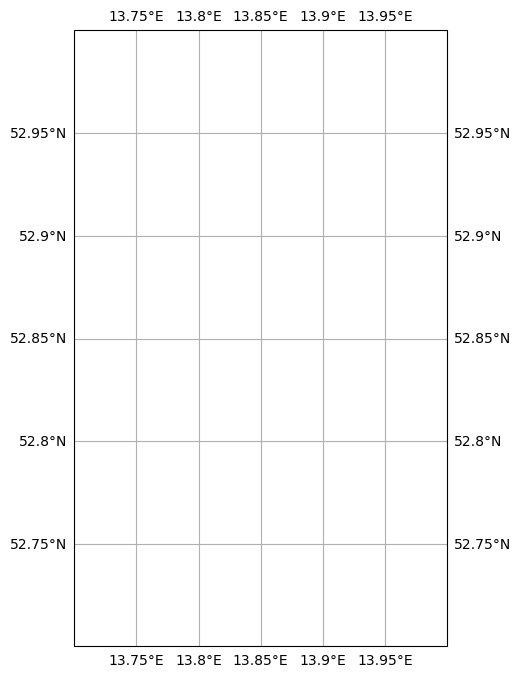

In [8]:
left, right, bottom, top = 13.7, 14, 52.7, 53,
# left, right, bottom, top = 13.275, 13.335, 52.535, 52.565,
# vmin and vmax define the minimum and maximum values for the color scale, respectively. When visualizing data, any data value less than or equal to vmin will be assigned the lowest color in the colormap, and any value greater than or equal to vmax will be assigned the highest color.
vmin=-3
vmax=15
cmap = cm.RdBu_r
units = 'Water Retention in m'
figsize = (20, 8)

#Test if we get the region right
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((left, right, bottom, top), crs=ccrs.PlateCarree())

# This adds coastlines to the map with a line width (lw) of 1 and a resolution of 10 meters. 
# The resolution indicates the level of detail of the coastlines.
ax.coastlines(lw=1, resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True)

In [9]:
# Creating a Mask for Data within the Defined Region:
# This line creates a mask for the data points that fall within the geographical boundaries defined by left, right, bottom, and top. 
# The mask will be used to filter or select data points from the model_lon and model_lat arrays that are within this region.
mask = np.where((model_lon > left)&(model_lon < right)&(model_lat>bottom)&(model_lat<top))
mask

(array([2232505, 2232506, 2232507, 2232508, 2236734, 2236735, 2236736,
        2240966, 2240967, 2240968, 2245202, 2245203, 2245204, 2249442,
        2249443, 2249444, 2249445, 2253686, 2253687, 2253688, 2253689,
        2257934, 2257935, 2257936, 2257937, 2262186, 2262187, 2262188,
        2262189, 2266443, 2266444, 2266445]),)

## Testing if the region is fine

In [10]:
# The [mask[0]] part filters the data to only include values that fall within the geographical boundaries defined earlier (using the mask created in the previous block).
WR_selected=WaterRetention.sel(time="2020-05-12 03:00:00")[mask[0]]
WR_selected

<xarray.DataArray (value: 32)>
dask.array<getitem, shape=(32,), dtype=float64, chunksize=(32,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    time     datetime64[ns] 2020-05-12T03:00:00
Dimensions without coordinates: value

In [11]:
# gridbox_values = np.hypot(gridbox_x, gridbox_y).values # for wind speed
WR_values = WR_selected.values
WR_values

array([24.30631615, 29.65864827, 31.84775255, 30.39745815, 30.31463985,
       30.63007156, 31.27480737, 26.86317829, 31.17927514, 32.17239968,
       29.9795207 , 26.06287684, 30.71408174, 26.29568474, 24.23012201,
       25.32726949, 30.33069533, 20.40105752, 23.28346541, 27.72252297,
       30.12422844, 23.84496965, 25.0889043 , 27.33158356, 27.56793149,
       29.59261079, 28.94726806, 30.73590949, 27.73626363, 28.72908965,
       29.1513225 , 25.42954853])

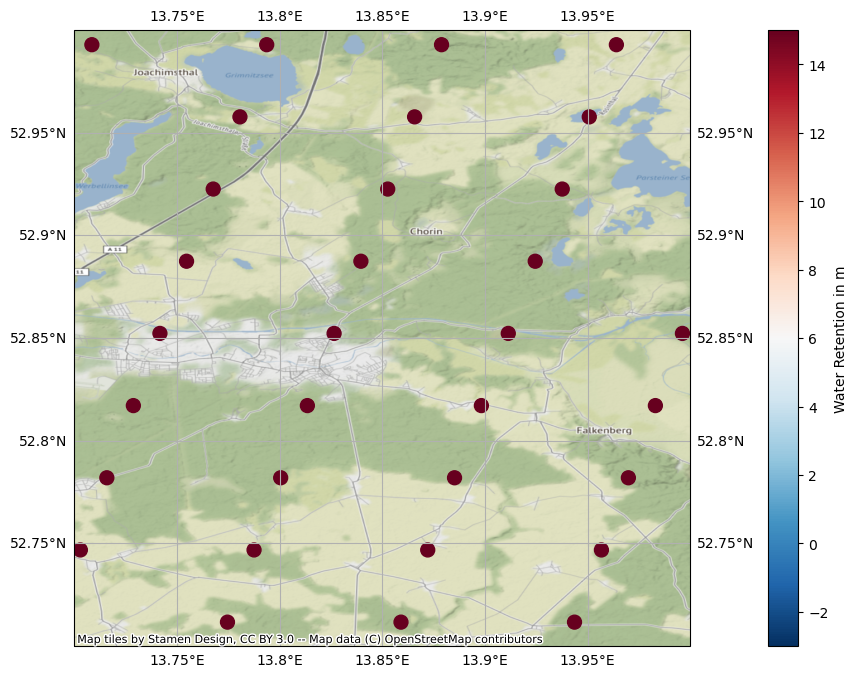

In [14]:
plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree())  # Note: Using PlateCarree for the main axis

# Set the extent
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

# Add the basemap first
ctx.add_basemap(ax, crs=ccrs.PlateCarree().proj4_init)

# Now, plot the temperature values on top of the basemap
im = ax.scatter(WaterRetention.lon[mask[0]], WaterRetention.lat[mask[0]], 
                c=WR_values, 
                s=100, 
                transform=ccrs.PlateCarree(),
                vmin=vmin, vmax=vmax, cmap=cmap
               )

ax.coastlines(lw=1, resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax.gridlines(draw_labels=True)
cb = plt.colorbar(im)
cb.set_label(units, size=10)
# plt.colorbar(im)


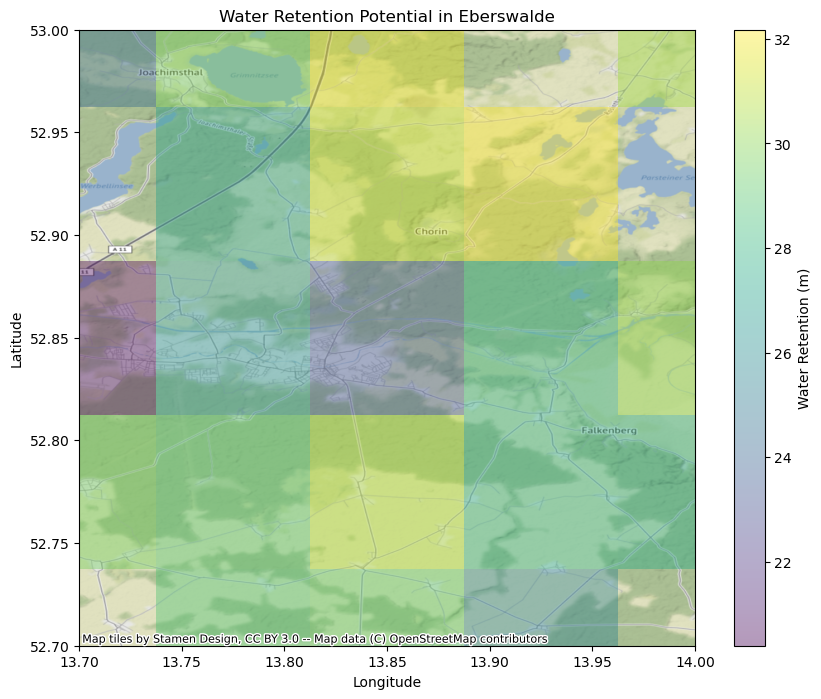

In [16]:
# Define the boundaries for Eberswalde
left, right = 13.7, 14
bottom, top = 52.7, 53

# Get the indices where the conditions are met
indices = np.where((WaterRetention.lon > left) & (WaterRetention.lon < right) & 
                   (WaterRetention.lat > bottom) & (WaterRetention.lat < top))

# Subset the data using the identified indices for a specific time
WaterRetention_Eberswalde = WaterRetention.sel(time="2020-05-12 03:00:00").isel(value=indices[0])

# Extract lat, lon, and values for plotting
lats = WaterRetention_Eberswalde.lat.values
lons = WaterRetention_Eberswalde.lon.values
values = WaterRetention_Eberswalde.values

# Create a grid for Eberswalde region
grid_lons = np.linspace(left, right, int(np.sqrt(values.size)))
grid_lats = np.linspace(bottom, top, int(np.sqrt(values.size)))
grid_values = np.full((len(grid_lats), len(grid_lons)), np.nan)  # Initialize with NaN

# Fill the grid cells corresponding to the data points
for lon, lat, value in zip(lons, lats, values):
    lon_idx = np.argmin(np.abs(grid_lons - lon))
    lat_idx = np.argmin(np.abs(grid_lats - lat))
    grid_values[lat_idx, lon_idx] = value

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
# Set the extent
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)
# Add the basemap first
ctx.add_basemap(ax, crs=ccrs.PlateCarree().proj4_init)
c = ax.pcolormesh(grid_lons, grid_lats, grid_values, shading='auto', alpha=0.4)
plt.colorbar(c, ax=ax, label="Water Retention (m)")
ax.set_title("Water Retention Potential in Eberswalde")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


### Visualizing independent timestamps and saving them as images.

In [45]:
timestamp_500 = WaterRetention['time'][500].values
print(timestamp_500)

2020-02-09T20:00:00.000000000


In [46]:
start_date = '2020-06-01'
end_date = '2020-08-31'
summer_indices = np.where((WaterRetention['time'].values >= np.datetime64(start_date)) & 
                          (WaterRetention['time'].values <= np.datetime64(end_date)))[0]
print(summer_indices)


[3192 3193 3194 ... 5374 5375 5376]


In [ ]:
%%time

# Loop over the desired timesteps
for i in range(3192, 3292):  # 701 to include timestep 700
    
    # Subset the data using the identified indices for a specific time
    WaterRetention_Eberswalde = WaterRetention.isel(time=i, value=indices[0])

    # Extract lat, lon, and values for plotting
    lats = WaterRetention_Eberswalde.lat.values
    lons = WaterRetention_Eberswalde.lon.values
    values = WaterRetention_Eberswalde.values

    # Create a grid for Eberswalde region
    grid_lons = np.linspace(left, right, int(np.sqrt(values.size)))
    grid_lats = np.linspace(bottom, top, int(np.sqrt(values.size)))
    grid_values = np.full((len(grid_lats), len(grid_lons)), np.nan)  # Initialize with NaN

    # Fill the grid cells corresponding to the data points
    for lon, lat, value in zip(lons, lats, values):
        lon_idx = np.argmin(np.abs(grid_lons - lon))
        lat_idx = np.argmin(np.abs(grid_lats - lat))
        grid_values[lat_idx, lon_idx] = value

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    # Set the extent
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    # Add the basemap first
    ctx.add_basemap(ax, crs=ccrs.PlateCarree().proj4_init)
    c = ax.pcolormesh(grid_lons, grid_lats, grid_values, shading='auto', alpha=0.4, vmin=vmin, vmax=vmax)
    plt.colorbar(c, label="Water Retention (m)")
    ax.set_title("Water Retention Potential in Eberswalde")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save the figure
    plt.savefig(f'/home/a/a270223/climaid_usecases/water_retention/plots/{str(i).zfill(7)}.png')
    # Close the figure to free up memory
    # plt.close(fig)


### Make the video from images

In [ ]:
# !pip install opencv-python IPython

In [18]:
def images_to_video(image_folder, output_video_name, fps):
    """
    Convert a sequence of images from a folder into a video.
    
    Parameters:
    - image_folder: Path to the folder containing the images.
    - output_video_name: Name of the output video file (e.g., 'output.mp4').
    - fps: Frames per second for the output video.
    """
    
    # Get all files from the folder
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    
    # Sort the images by name
    images.sort()
    
    # Determine the width and height from the first image
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    h, w, layers = frame.shape
    size = (w, h)
    
    # Create a video writer object
    out = cv2.VideoWriter(output_video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    
    # Read each image and write it to the video
    for image in images:
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        out.write(img)
    
    out.release()

# Use the function
image_folder = '/home/a/a270223/climaid_usecases/water_retention/video/'  # Replace with the path to your folder containing the images
output_video_name = 'output_water_ret.mp4'
fps = 30  # You can adjust this value based on your preference

images_to_video(image_folder, output_video_name, fps)


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
